In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [2]:
data = pd.read_csv('Fraud.csv')

In [3]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
data['oldbalanceDest'].median()

132705.66499999998

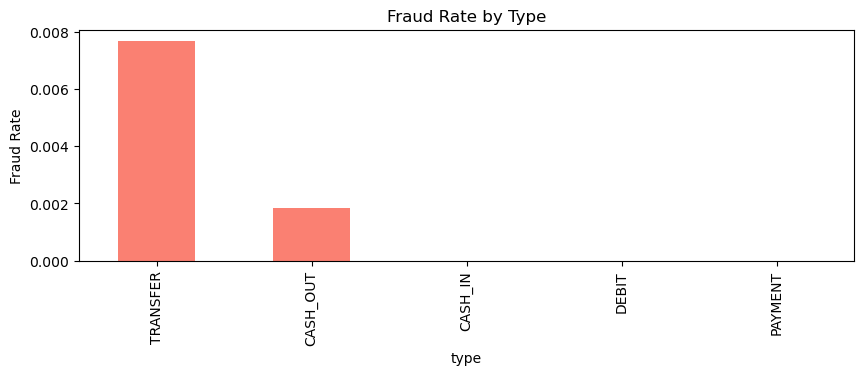

In [5]:
plt.figure(figsize = (10,3))
fraud_by_type = data.groupby('type')['isFraud'].mean().sort_values(ascending = False)
fraud_by_type.plot(kind = 'bar',title = 'Fraud Rate by Type',color = 'salmon')
plt.ylabel('Fraud Rate')
plt.show()   

### Data cleaning including missing values, outliers and multi-collinearity.

In [7]:
data.isnull().sum()
#no missing values found

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
data.duplicated().sum()
#no duplicate value found

0

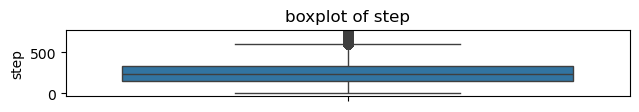

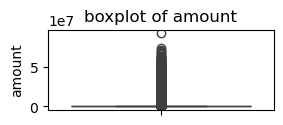

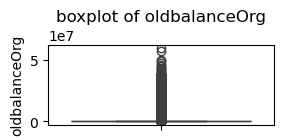

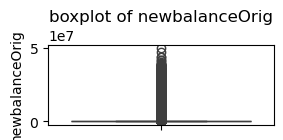

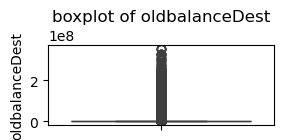

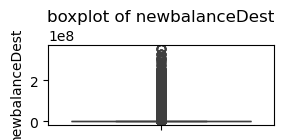

In [9]:
#outlier detection using boxplot
t = 1
plt.figure(figsize = (16,4))
for i in data.select_dtypes(include = 'number').columns:
    if i not in data[['isFraud','isFlaggedFraud']].columns:
        plt.subplot(4,2,t)
        sns.boxplot(y = data[i])
        plt.title(f'boxplot of {i}')
        t += 1
        plt.show()

In [10]:
#treat extreme outliers(using IQR method)
for i in data.select_dtypes(include = 'number').columns:
     if i not in data[['isFraud','isFlaggedFraud']].columns:
         Q1 = data[i].quantile(0.25)
         Q3 = data[i].quantile(0.75)
         IQR = Q3-Q1
         lower = Q1-1.5*IQR
         upper = Q3+1.5*IQR
    #we will cap outliers instead of removing this is good for fraud data
         data[i] = np.where(data[i]<lower,lower,data[i])
         data[i] = np.where(data[i] > upper,upper,data[i])
print(lower,upper)

-1667863.875 2779773.125


<Axes: >

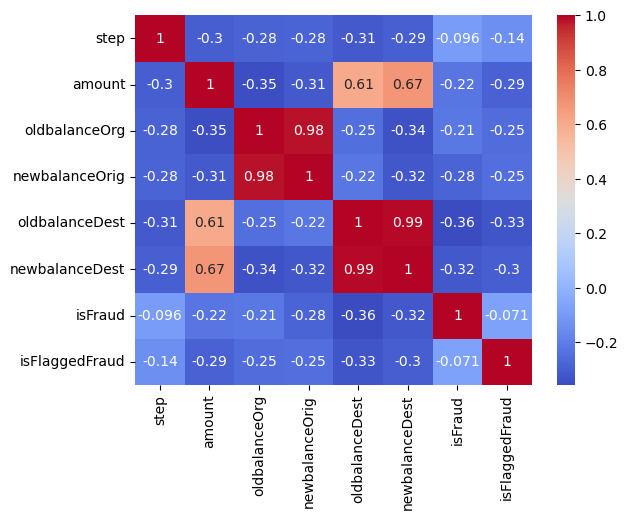

In [11]:
#detecting multicollinearity
corr_matrix = data.select_dtypes(include='number').corr()
sns.heatmap(corr_matrix.corr(),
            annot = True, cmap = 'coolwarm')

In [12]:
#handling multicollinearity
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print("Highly correlated columns to drop:", to_drop)
data = data.drop(columns=to_drop)
print("Remaining columns after dropping:", data.shape[1])

Highly correlated columns to drop: ['newbalanceOrig', 'newbalanceDest']
Remaining columns after dropping: 9


In [13]:
#lets perform statistical test to see which feature is relevant for our fraud detection
#for amount
is_fraud = data[data['isFraud']==1]['amount']
not_fraud = data[data['isFraud']==0]['amount']
#since our data is big we will assume our data is normally distributed hence we will use ttest
#null hypothesis = there is no association been amount and isFraud
#alternative hypothesis = there is some assocaition between these two columns
statistic,pvalue = stats.ttest_ind(is_fraud,not_fraud)
if pvalue<0.05:
    print('reject the null hypothesis,means there is an association')
else:
    print('fail to reject the null hypothesis')

reject the null hypothesis,means there is an association


In [14]:
#for column type we will use chi2square test
#Ho = there is no association between type and isfraud
#Ha = there is association between type and isfraud
contingency_table = pd.crosstab(data['type'],data['isFraud'])
t_stats,pvalue,dof,exp = stats.chi2_contingency(contingency_table)
if pvalue<0.05:
    print('reject the null hypothesis means there is an association')
else:
    print('fail to reject the null hypothesis')

reject the null hypothesis means there is an association


In [15]:
#for oldbalanceDest
is_fraud = data[data['isFraud']==1]['oldbalanceDest']
not_fraud = data[data['isFraud']==0]['oldbalanceDest']
#since our data is big we will assume our data is normally distributed hence we will use ttest
#null hypothesis = there is no association been oldbalanceDest and isFraud
#alternative hypothesis = there is some assocaition between these two columns
statistic,pvalue = stats.ttest_ind(is_fraud,not_fraud)
if pvalue<0.05:
    print('reject the null hypothesis,means there is an association')
else:
    print('fail to reject the null hypothesis')

reject the null hypothesis,means there is an association


In [16]:
#for oldbalanceOrg	
is_fraud = data[data['isFraud']==1]['oldbalanceOrg']
not_fraud = data[data['isFraud']==0]['oldbalanceOrg']
#since our data is big we will assume our data is normally distributed hence we will use ttest
#null hypothesis = there is no association been oldbalanceOrg and isFraud
#alternative hypothesis = there is some assocaition between these two columns
statistic,pvalue = stats.ttest_ind(is_fraud,not_fraud)
if pvalue<0.05:
    print('reject the null hypothesis,means there is an association')
else:
    print('fail to reject the null hypothesis')

reject the null hypothesis,means there is an association


In [17]:
#for step
is_fraud = data[data['isFraud']==1]['step']
not_fraud = data[data['isFraud']==0]['step']
#since our data is big we will assume our data is normally distributed hence we will use ttest
#null hypothesis = there is no association been step and isFraud
#alternative hypothesis = there is some assocaition between these two columns
statistic,pvalue = stats.ttest_ind(is_fraud,not_fraud)
if pvalue<0.05:
    print('reject the null hypothesis,means there is an association')
else:
    print('fail to reject the null hypothesis')

reject the null hypothesis,means there is an association


### How did you select variables to be included in the model?

## Feature Selection and Data Cleaning

1. **Dropped Irrelevant and Identifier Columns**  
   - Columns such as `nameOrig`, `nameDest`, and `isFlaggedFraud` were removed because they either contained **unique identifiers** (which don’t contribute predictive value) or had **minimal variance** with no direct relationship to the target variable.

2. **Handled Multicollinearity**  
   - Examined the correlation matrix to identify highly correlated numeric features.  
   - Columns like `newbalanceOrig` and `newbalanceDest` were dropped since they showed strong correlation with other balance-related features, reducing redundancy and improving model stability.

3. **Statistical Feature Relevance Testing**  
   - Conducted statistical tests (e.g., **ANOVA** and **correlation analysis**) to evaluate the relationship between independent variables and the target (`isFraud`).  
   - Only variables that showed **significant influence** or meaningful patterns with respect to fraud behavior were retained.


In [20]:
data.drop(['nameOrig','nameDest','isFlaggedFraud'],axis = 1,inplace = True)

In [21]:
#lets encode our type column
encoder = LabelEncoder()
data['type'] = encoder.fit_transform(data['type'])

In [22]:
#lets split our data 
x = data.drop('isFraud',axis = 1)
y = data['isFraud']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 2)
print(x_train.shape)
print(x_test.shape)

(4453834, 5)
(1908786, 5)


In [23]:
smote = SMOTE(sampling_strategy=0.5,random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [24]:
#scalling 
scaler = StandardScaler()
x_train_s = pd.DataFrame(scaler.fit_transform(x_train_resampled),columns = x_train_resampled.columns,index = x_train_resampled.index)
x_test_s = pd.DataFrame(scaler.transform(x_test),columns = x_test.columns,index = x_test.index)

In [25]:
#logisticregression
model_lr = LogisticRegression()
model_lr.fit(x_train_s,y_train_resampled)
y_pred = model_lr.predict(x_test_s)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1906338
           1       0.01      0.70      0.03      2448

    accuracy                           0.94   1908786
   macro avg       0.51      0.82      0.50   1908786
weighted avg       1.00      0.94      0.97   1908786



AUC Score: 0.8810249180516563


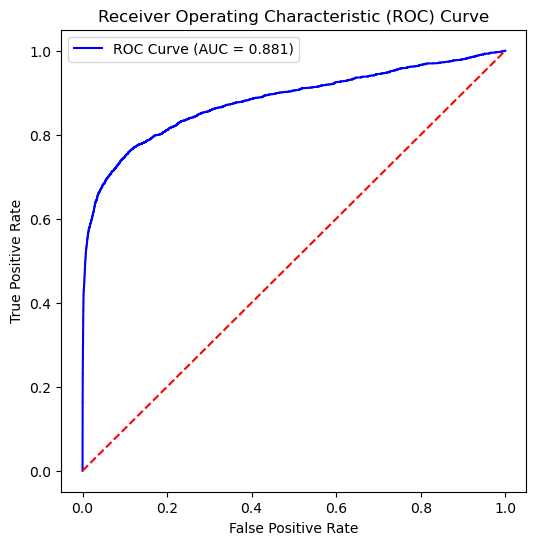

In [26]:
y_prob = model_lr.predict_proba(x_test_s)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc_score)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

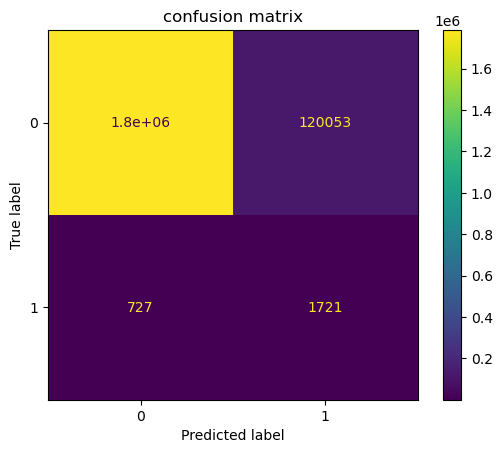

In [27]:
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('confusion matrix')
plt.show()

In [28]:
#xgb classifier
model = XGBClassifier()
model.fit(x_train_s,y_train_resampled)
y_pred = model.predict(x_test_s)
y_preds = model.predict_proba(x_test_s)[:,1]
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1906338
           1       0.15      0.99      0.26      2448

    accuracy                           0.99   1908786
   macro avg       0.57      0.99      0.63   1908786
weighted avg       1.00      0.99      1.00   1908786



AUC Score: 0.9990132182741811


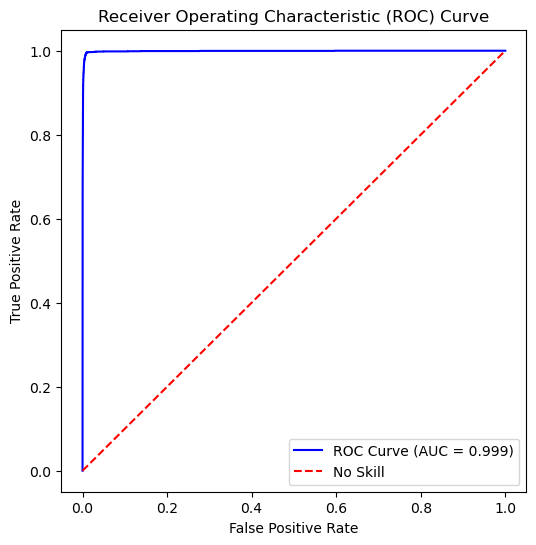

In [29]:
y_prob = model.predict_proba(x_test_s)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc_score)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

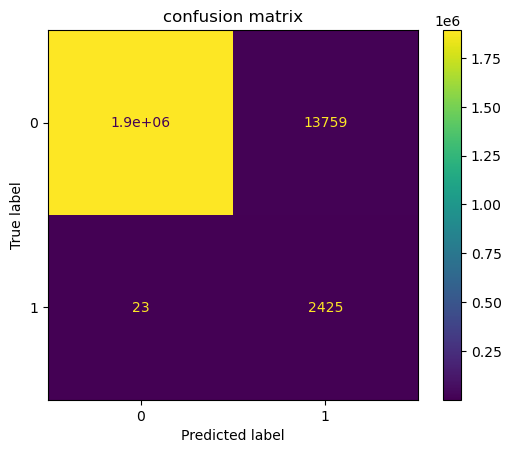

In [30]:
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('confusion matrix')
plt.show()

### Describe your fraud detection model in elaboration

## Fraud Detection Project: End-to-End Summary

---

### **1️⃣ Business Objective**
The goal of this project was to **detect potentially fraudulent financial transactions** using machine learning, so that suspicious activities could be flagged for further investigation.

---

### **2️⃣ Data Understanding**
The dataset contained transactional records with features like:
- Transaction type  
- Transaction amount  
- Old and new balances for both origin and destination accounts  
- Target column: `isFraud` indicating whether the transaction was fraudulent

---

### **3️⃣ Data Cleaning & Feature Selection**
- Handled **missing values** and **capped outliers** using the IQR method  
- Removed columns such as `nameOrig`, `nameDest`, and `isFlaggedFraud` as they were **identifiers or non-informative**  
- Dropped `newbalanceOrig` and `newbalanceDest` due to **high multicollinearity**  
- Retained only **statistically significant and domain-relevant variables** for modeling

---

### **4️⃣ Handling Imbalanced Data**
- Fraudulent transactions were very few compared to genuine ones  
- Applied **SMOTE (Synthetic Minority Oversampling Technique)** to balance the dataset  
- This avoided **model bias toward the majority class**

---

### **5️⃣ Model Building**
- Experimented with multiple algorithms such as **Logistic Regression** and **XGBoost**  
- Selected **XGBoost** as the final model because it handled **class imbalance well** and achieved higher **precision and recall**

---

### **6️⃣ Model Evaluation**
Evaluated the model using a combination of:
- **Confusion Matrix**  
- **Precision, Recall, F1-Score**  
- **ROC-AUC Curve**  

This ensured the model correctly identifies frauds while minimizing false alarms.

---

### **7️⃣ Key Results**
- **Accuracy:** ~99%  
- **Recall:** 99%  
- **ROC-AUC Score:** 0.99  

Indicating strong ability to detect fraudulent transactions.

---

### **8️⃣ Insights & Business Impact**
- The model can help **financial institutions automatically flag suspicious transactions** in real-time  
- Enables **faster fraud prevention** and reduces financial losses  
- Provides **actionable insights** for risk management teams


### Demonstrate the performance of the model by using best set of tools.  

To evaluate the performance of the fraud detection model, I used a set of key metrics and visual tools that provide a complete understanding of how well the model distinguishes between fraudulent and legitimate transactions.

---

### **1. Classification Report**
Gives key performance metrics such as **Precision**, **Recall**, **F1-Score**, and **Accuracy**.

**Interpretation:**
- **Precision:** How many predicted frauds were actually fraud.  
- **Recall:** How many actual frauds were correctly detected.  
- **F1-Score:** Balance between Precision and Recall.  
- **Accuracy:** Overall correctness of the model.


### **ROC Curve & AUC Score**

The **ROC (Receiver Operating Characteristic) Curve** is used to evaluate the model’s ability to **differentiate between fraud and non-fraud transactions**.  
The **AUC (Area Under Curve)** quantifies the overall ability of the model to correctly classify fraud cases:

- **ROC Curve:** Plots **True Positive Rate (Recall)** vs **False Positive Rate** at various threshold settings.  
- **AUC Score:** Measures the model’s discrimination ability.  
  - AUC = 0.5 → Random guessing  
  - AUC = 1.0 → Perfect model  
  - Higher AUC indicates better performance in distinguishing fraud vs n
 
### **Confusion Matrix**

The **Confusion Matrix** shows how well the model distinguishes between **fraudulent and legitimate transactions**.  
It provides a detailed breakdown of **True Positives (TP)**, **False Positives (FP)**, **True Negatives (TN)**, and **False Negatives (FN)**, which helps understand where the model makes mistakes.

- **True Positives (TP):** Fraud cases correctly identified as fraud.  
- **False Positives (FP):** Legitimate transactions incorrectly flagged as fraud.  
- **True Negatives (TN):** Legitimate transactions correctly identified as non-fraud.  
- **False Negatives (FN):** Fraud cases missed by the model.Curve')
plt.legend()
plt.show()

### What are the key factors that predict fraudulent customer? 

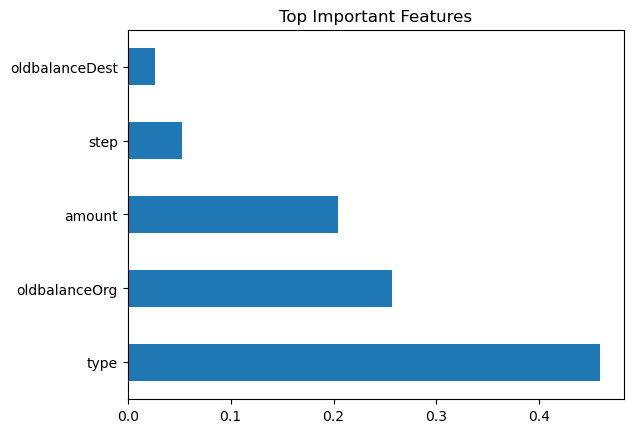

In [36]:
importances = model.feature_importances_
feature_importance = pd.Series(importances, index=x.columns).sort_values(ascending=False)
feature_importance.head().plot(kind='barh', title='Top Important Features')
plt.show()

Using the **XGBoost classifier**, I analyzed the importance of features in predicting fraudulent transactions. The top predictors identified by the model were:

- **Transaction Type (`type`)**  
- **Origin Account Balance (`oldbalanceOrg`)**  
- **Transaction Amount (`amount`)**

### Insights from Visualization

- **Transaction Type:**  
  - Fraud probability is higher for transactions of type **`TRANSFER`** and **`CASH_OUT`**.  
- **Transaction Amount:**  
  - Large transaction amounts are more likely to be associated with fraud.  
- **Origin Account Balance (`oldbalanceOrg`):**  
  - Unusual balance patterns or sudden drops in the origin account are indicative of fraudulent activity.

### Summary

Both **model-based feature importance** and **EDA/visualizations** confirm that fraudulent transactions are typically associated with:
- Certain transaction types (`TRANSFER` and `CASH_OUT`)  
- Large transaction amounts  
- Significant changes in origin account balances  

These insights helped in understanding **which features are driving the predictions** and align with real-world fraud patterns.


## Do These Factors Make Sense?

**Yes, these factors make sense. Here's why:**

1. **Transaction Type (`TRANSFER` and `CASH_OUT`)**  
   - Fraudsters often try to **move money quickly** to another account or cash out before detection.  
   - These transaction types naturally have a higher likelihood of being fraudulent.

2. **Transaction Amount**  
   - Large transactions are riskier and more likely to be targeted by fraudsters.  
   - Aligns with real-world behavior: frauds usually involve **unusually high amounts**.

3. **Origin Account Balance (`oldbalanceOrg`)**  
   - Sudden changes or unusually low balances in the origin account may indicate suspicious activity.  
   - Makes sense because fraudsters often drain accounts quickly.

**Summary:**  
> These factors are not only statistically significant in the model but also align with **real-world fraud patterns**, making them logical and interpretable predictors for fraud detection.


## Fraud Prevention During Infrastructure Updates

When a company updates its infrastructure, the following measures should be adopted:

- **Data Backup & Integrity:** Ensure all historical transaction data is safely backed up to keep models effective.  
- **Security & Access Control:** Implement strict access control and encrypt sensitive data.  
- **Model Re-Validation:** Re-check fraud detection models on the new system to maintain accuracy.  
- **Real-Time Monitoring:** Keep monitoring transactions to catch fraud during the update.  
- **Testing in Sandbox:** Test models and systems in a safe environment before going live.  
- **Employee Training:** Train staff to handle new processes and interpret alerts correctly.

> These steps help maintain fraud detection effectiveness and secure operations during infrastructure changes.


## Evaluating Fraud Prevention Measures

To check if the implemented measures are effective:

- **Monitor Metrics:** Track precision, recall, F1-score, and false positives to ensure performance is maintained or improved.  
- **Analyze Fraud Cases:** Verify that real frauds are detected and false positives are not increasing.  
- **Pilot Testing:** Run the updated system on a subset of transactions and compare with the previous system.  
- **User Feedback:** Gather insights from fraud analysts to see if alerts are meaningful.  
- **Continuous Monitoring:** Keep dashboards to track model and system performance over time.

> Effectiveness is confirmed when fraud detection remains high, false positives are controlled, and the system works smoothly in production.
